In [1]:
import sys
sys.path.append("..")

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
from os.path import exists

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

In [2]:
from laos_gggi.combine_data import final_data

# Data

In [3]:
#Load data
data = final_data()
df_clim = data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1] 
emdat_damage = data["emdat_damage"]["Total_Damage_Adjusted"]
development_indicators = data["wb_data"]

#Fill NaN values
emdat_damage_filled = emdat_damage.fillna(0)

#Normalize climate data
df_clim_norm = (df_clim - df_clim.mean())/df_clim.std()

In [4]:
#Integrate all the data sets
df = (pd.merge(emdat_damage_filled.reset_index().rename(columns = {"Start_Year": "year"}).set_index("year"), df_clim_norm, right_index= True, left_index=True, how = "left")
      .fillna(0)
      .reset_index()
      .set_index(["ISO", "year"])
     )


df = (pd.merge(df, development_indicators.reset_index().rename(columns = {"Start_Year": "year"}).set_index(["ISO", "year"]), right_index= True, left_index=True, how = "left"))
df = df.reset_index()

#Drop NaN
df = df.dropna()

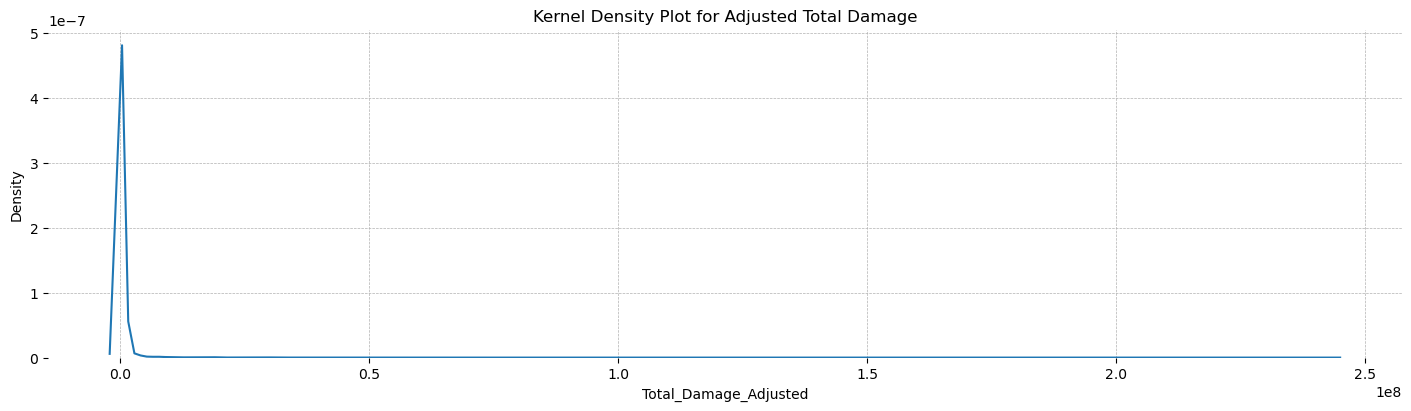

In [5]:
sns.kdeplot(emdat_damage_filled)
plt.title("Kernel Density Plot for Adjusted Total Damage") ;

# Model

In [6]:
#Set coordinates
ISO_idx, ISO =  pd.factorize(df["ISO"])
obs_idx = df.index

COORDS = {'ISO':ISO, 
          #'Year_vals':df['Start_Year'].cat.categories.values,
          "obs_idx": obs_idx}

In [7]:
with pm.Model(coords=COORDS) as damages_model:

    #Declare data
    damages = pm.Data("damages", df["Total_Damage_Adjusted"]  , dims=["obs_idx"])
    co2 = pm.Data("co2", df["co2"]  , dims=["obs_idx"])
    temp = pm.Data("temp", df["Temp"]  , dims=["obs_idx"])
    gdp_per_cap = pm.Data("gdp_per_cap", df["gdp_per_cap"]  , dims=["obs_idx"])
    population_density = pm.Data("population_density", df["population_density"]  , dims=["obs_idx"])

    #Country effect
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 10)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
    
   # b2 = pm.Normal("Year", mu=0, sigma=1, dims="Year_vals")
    Ocean_temp_effect = pm.Normal("Ocean_temp_effect", mu=0, sigma=1)
    CO2_effect = pm.Normal("CO2_effect", mu=0, sigma=1)
    
    #Development indicators: 
    gdp_per_cap_effect = pm.Normal("gdp_per_cap_effect", mu=0, sigma=10)
    population_density_effect = pm.Normal("population_density_effect", mu=0, sigma=1)



    theta = (country_effect[ISO_idx]+ Ocean_temp_effect*temp + CO2_effect*co2 + gdp_per_cap_effect*gdp_per_cap + population_density_effect*population_density)
    sigma = pm.Exponential("sigma", 1)

    # ## Define likelihood
    y_hat = pm.Normal("y_hat", mu= theta, sigma = sigma, observed=damages, dims = "obs_idx")

In [8]:
with damages_model:
    prior_idata = pm.sample_prior_predictive( )

prior_idata.prior_predictive =  prior_idata.prior_predictive.assign_coords({"obs_idx":obs_idx})

Sampling: [CO2_effect, Ocean_temp_effect, country_effect_mu, country_effect_offset, country_effect_scale, gdp_per_cap_effect, population_density_effect, sigma, y_hat]


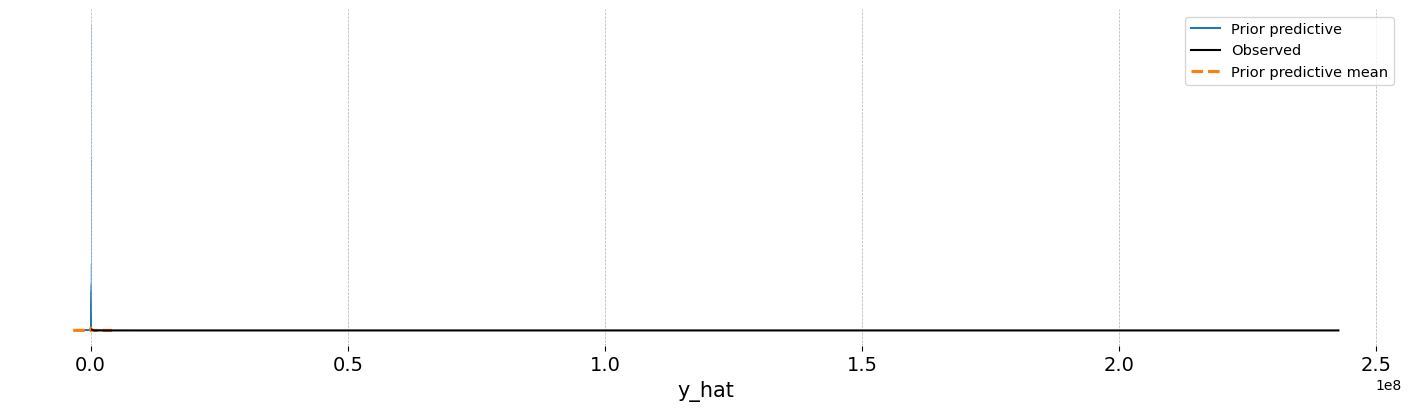

In [9]:
az.plot_ppc(prior_idata, group = "prior", observed = prior_idata.observed_data );

## Sampling

In [10]:
#Sampling
with damages_model:
    damages_idata = pm.sample(nuts_sampler='nutpie', chains=8, draws=1000)
    damages_idata = pm.sample_posterior_predictive(damages_idata, 
                                                predictions=True, 
                                                return_inferencedata=True, extend_inferencedata=True).assign_coords({"obs_idx":obs_idx}) 

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.48,7
,2000,0,0.47,7
,2000,0,0.47,7
,2000,0,0.47,7
,2000,0,0.46,7
,2000,0,0.48,7
,2000,0,0.00,1023
,2000,0,0.00,1023


Sampling: [y_hat]


Output()

# Diagnosis

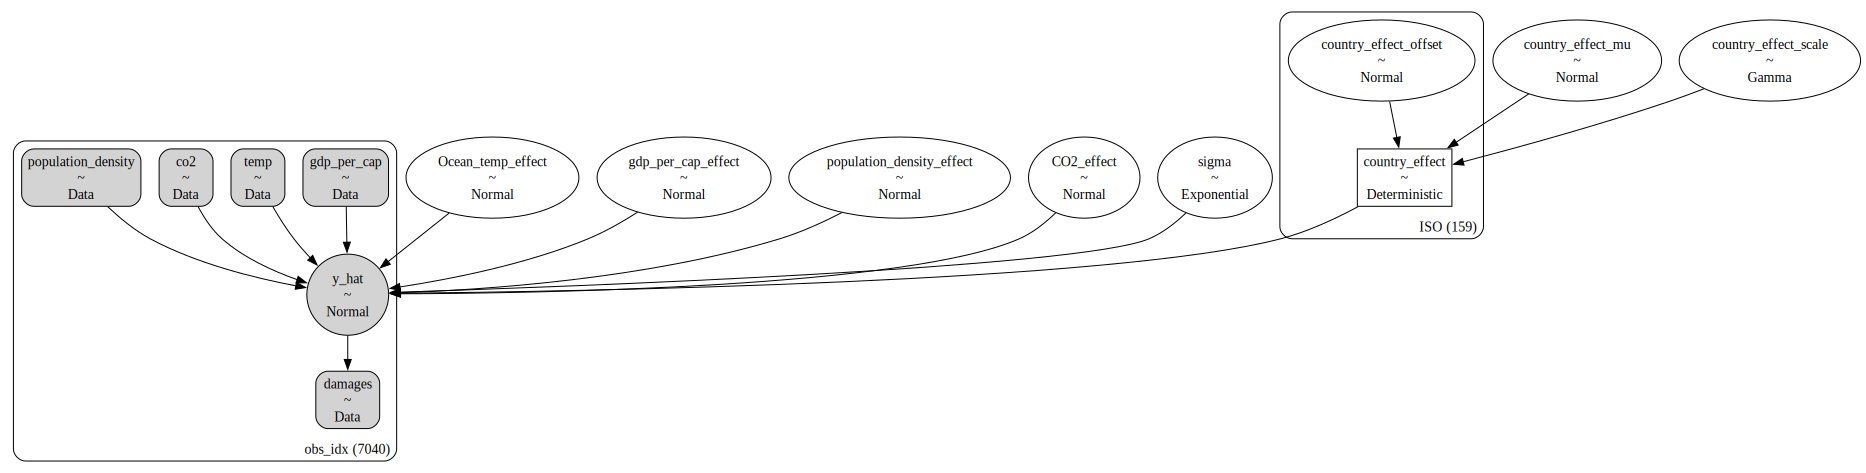

In [11]:
pm.model_to_graphviz(damages_model)

In [12]:
az.summary(
    damages_idata,
    var_names=["country_effect_mu", "country_effect_scale", "Ocean_temp_effect", "CO2_effect", "sigma"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
country_effect_mu,0.571,8.639,-16.232,19.209,0.091,0.634,2603.0,3930.0,1.42
country_effect_scale,1279.412,2377.138,0.462,6849.226,837.077,614.736,14.0,3309.0,1.55
Ocean_temp_effect,-0.020,0.874,-1.733,1.668,0.038,0.060,345.0,2588.0,1.09
CO2_effect,0.133,1.181,-1.650,2.010,0.276,0.198,21.0,30.0,1.28
sigma,408756.871,236008.888,0.371,545605.176,83107.208,61032.603,14.0,8.0,1.55


C:\Users\camil\anaconda3\envs\laos-climate-change\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\camil\anaconda3\envs\laos-climate-change\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\camil\anaconda3\envs\laos-climate-change\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\camil\anaconda3\envs\laos-climate-change\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single valu

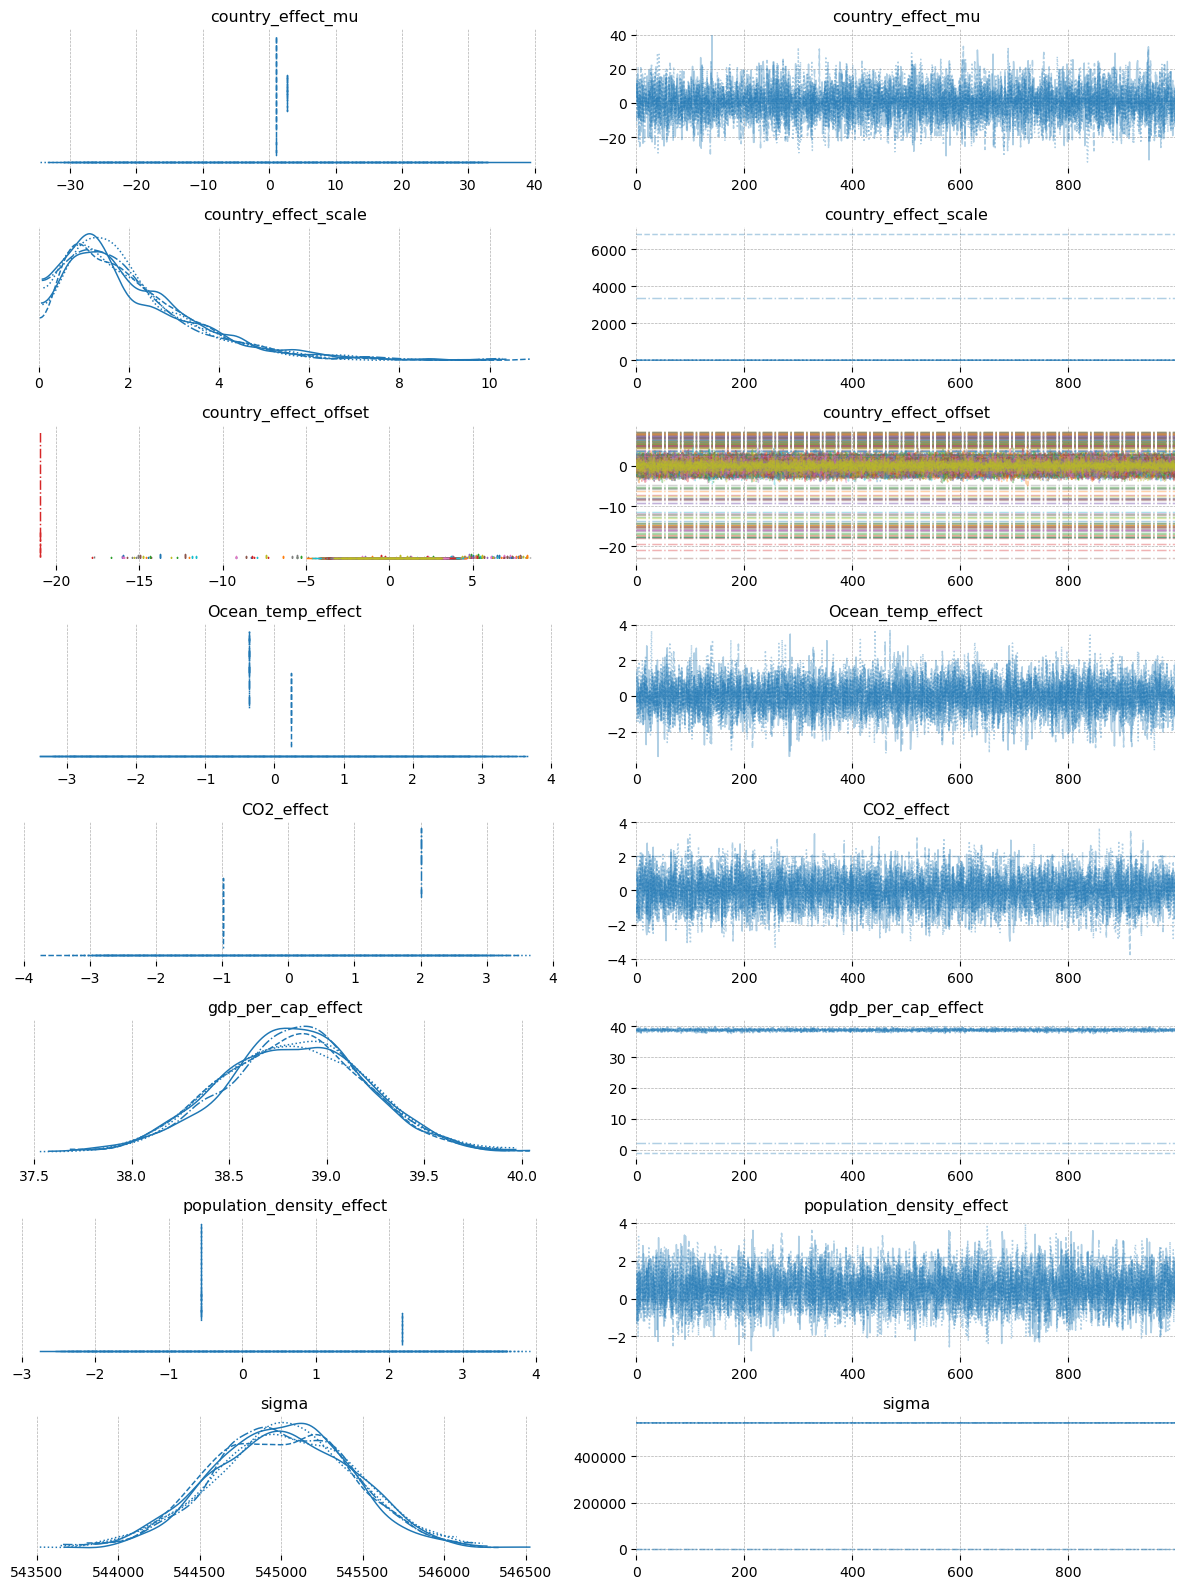

In [13]:
trace_vars = [rv.name for rv in damages_model.free_RVs]

az.plot_trace(damages_idata, var_names=trace_vars)
plt.tight_layout();

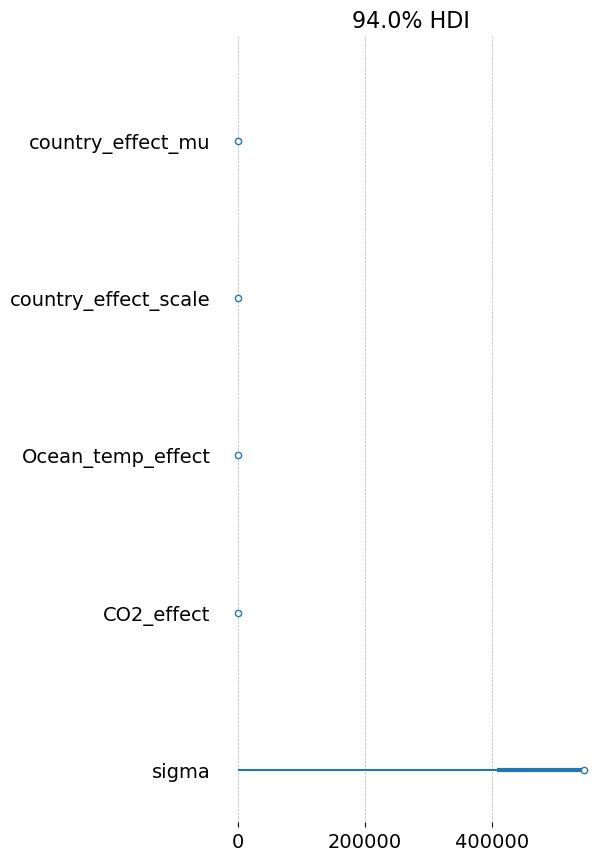

In [14]:
az.plot_forest(damages_idata, var_names = ["country_effect_mu", "country_effect_scale", "Ocean_temp_effect", "CO2_effect", "sigma"], combined= True);